# <center>NTDS Project: How Do Fake-News Go Viral ?</center>
# <center>[Or why Bernie Sanders could replace President Trump with little-known loophole](http://www.huffingtonpost.com/entry/bernie-sanders-could-replace-president-trump-with-little_us_5829f25fe4b02b1f5257a6b7)</center>

Authors: *Victor Kristof* and *William Trouleau*

---

The click-bait headline of the title, published on November 14, 2016 by the Huffington Post, is clearly fake (and on purpose). It cleverly shades light on an issue that became mainstream with the recent US election: fake-news propaganda on social networks. Indeed, an analysis of user engagement performed by BuzzFeed concluded that fake-news stories raised more engagement on Facebook than the top election story from 19 major news outlets combined. The idea of this project is to analyze posts from famous Facebook pages publishing articles related to the US elections and to measure the impact of misinformation on the elections.

In particular, we follow the [analysis](https://www.buzzfeed.com/craigsilverman/partisan-fb-pages-analysis) of BuzzFeed on nine famous Facebook pages actively publishing articles related to the US elections:

* Mainstream pages: [Politico](https://www.facebook.com/politico), [CNN]({https://www.facebook.com/cnn) and [ABC News Politics](https://www.facebook.com/ABCNewsPolitics),
* Pro-democrate pages: [The Other 98%](https://www.facebook.com/TheOther98), [Addicting Info](https://www.facebook.com/AddictingInfoOrg) and [Occupy Democrats](https://www.facebook.com/OccupyDemocrats),
* Pro-republican pages: [Eagle Rising](https://www.facebook.com/theEagleisRising), [Right Wing News](https://www.facebook.com/OfficialRightWingNews) and [Freedom Daily](https://www.facebook.com/FreedomDailyNews).

BuzzFeed manually anotated all articles posted by these nine pages during one week in September 2016, and rated them according to the accuracy of the information published. More information on these ratings is developed in Section 1. However, their analysis was limited to the exploration of engagement metrics like the number of reactions, comments or shares generated by fake-news articles.

In this project, we extract additional features of the posts like the text message, the type of content, and so on. We then apply Machine Learning techniques to automatically detect fake-news ratings from unlabelled posts.

---

* In **Section 1. (Acquisition)**, we first detail the scraping process to acquire the Facebook posts used throughout the project. We then clean the data and save it to a csv file for future use.

* In **Section 2. (Exploration)**, we then explore the scraped data. We first investigate the **volume of data** that was scraped for each page and for each political orientation. We then dig deeper and investigate the **text messages** that will later be used for exploitation. We explore how these messages relate to the **truthfulness** of the articles. Since we also extracted other kind of features, we investigate them in the same way.

* In **Section 3. (Exploitation/Evaluation)**, we finally use the scraped data to build a detection algorithm to predict wether or not a given Facebook post is propaganda. We tackle this problem with three different approaches. 
    * The first two approaches aim at detecting the truthfulness of articles based only on the text messages of the post. We take inspiration from *Sentiment Analysis* modeling, but here we try to predict truthfulness rather than sentiment. In particular, we first build a simple **Naive Bayes classifier**, but its limitations are quickly reached. We then implement a more involved model based on **Convolutional Neural Networks** that is the state-of-the-art for Sentiment Analysis.
    * Finally, we also build a last model based on other non-textual features that were found to be discriminative in the exporation step.

In [1]:
import numpy as np
import scipy

import matplotlib as mpl
mpl.use('svg')
%matplotlib inline
from matplotlib import pyplot as plt

from cycler import cycler
palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
mpl.rcParams.update({
    'axes.prop_cycle': cycler(color=palette),
    'font.sans-serif': 'Helvetica',
    'font.style': 'normal',
    'font.size': 10,
})

import warnings
warnings.filterwarnings("ignore")

import pandas as pd

# Load internal libraries
%load_ext autoreload
%autoreload 2
import lib
from lib.acquisition import Feature, FacebookScraper
from lib import exploration, exploration_helper
from lib import ntds_utils
from lib import utils
from lib import config

---

# 1. Data Acquisition

***NOTE:*** In order to run the data acquisition process, one needs to obtain a token to connect to the Facebook Graph API. This token needs to be saved in a credentials file (by default `credentials.ini` in the current directory).

We collect data from nine famous Facebook pages actively publishing articles related to the US elections:

* Mainstream pages: [Politico](https://www.facebook.com/politico), [CNN]({https://www.facebook.com/cnn) and [ABC News Politics](https://www.facebook.com/ABCNewsPolitics),
* Pro-democrate pages: [The Other 98%](https://www.facebook.com/TheOther98), [Addicting Info](https://www.facebook.com/AddictingInfoOrg) and [Occupy Democrats](https://www.facebook.com/OccupyDemocrats),
* Pro-republican pages: [Eagle Rising](https://www.facebook.com/theEagleisRising), [Right Wing News](https://www.facebook.com/OfficialRightWingNews) and [Freedom Daily](https://www.facebook.com/FreedomDailyNews).

Each collected post includes the name of the page in addition to:
* the post id `post_id`,
* the URL of the post `post_url`, 
* the time `created_time` when the post was created , 
* the type of post `type` (i.e. status, link, video, photo), 
* the text `message` of the post, 
* the number of times the post was shared `share_count`,
* the number of times the post received a reaction `reaction_count`,
* the number of times the post was commented `comment_count`.


## 1.1 Facebook Web Scraper

To have better flexibility on the scraping process, we collect data using the low-level approach with the `requests` library. The code of the scraper `FacebookScraper`, as well as all the code corresponding to the data collection part, is contained in the `acquisition` module.

The `FacebookScraper` takes an iterable of `Feature`s which represents the fields we want to query on the Facebook Graph API and provide a convenient way to query, clean and save the raw data into a well-formatted `pandas.DataFrame`. 

#### Parameters

Define the parameters for the web scraper:
* Credential file where your token is located
* List of the pages to scrape
* Date range over which we want to collect data
* Fields to query

In [2]:
# Credential file containing the Facebook authentication token
credentials_file = 'credentials.ini'

# List of pages to scrape
page_list = ['ABCNewsPolitics', 'cnnpolitics', 'politico', 
             'AddictingInfoOrg', 'OccupyDemocrats', 'TheOther98', 
             'FreedomDailyNews', 'OfficialRightWingNews', 'theEagleisRising']

# Define the date range to scrape
start_date = '2016/01/01'
end_date = '2016/12/05'

# Define the fields to query
field_list = [
    Feature('id', name='post_id'),
    Feature('permalink_url', name='post_url'),
    Feature('link'),
    Feature('created_time'),
    Feature('type'),
    Feature('message'),
    Feature('description'),
    Feature('picture'),
    Feature('status_type'),
    Feature('caption'),
    Feature('reactions.limit(0).summary(1)', 
            formatter=lambda data: data.get('reactions', {'summary':{'total_count':0}})['summary']['total_count'], 
            name='reaction_count'),
    Feature('comments.limit(0).summary(1)', 
            formatter=lambda data: data.get('comments', {'summary':{'total_count':0}})['summary']['total_count'], 
            name='comment_count'),
    Feature('shares', 
            formatter=lambda data: data.get('shares', {'count': 0})['count'],
            name='share_count')
]

print('We collect data corresponding to fields:', ', '.join([f.fbquery for f in field_list]))
print('from the Facebook pages: ', ', '.join(page_list))

We collect data corresponding to fields: id, permalink_url, link, created_time, type, message, description, picture, status_type, caption, reactions.limit(0).summary(1), comments.limit(0).summary(1), shares
from the Facebook pages:  ABCNewsPolitics, cnnpolitics, politico, AddictingInfoOrg, OccupyDemocrats, TheOther98, FreedomDailyNews, OfficialRightWingNews, theEagleisRising


Run the web scraper.

**WARNING: By running this cell, you will crawl ~60Mb of data from Facebook.**

In [ ]:
# Initialize the Facebook web scraper
scraper = FacebookScraper(field_list)
scraper.extract_token(credentials_file)

# Iterate over the Facebook pages
for page in page_list:
    try:
        print('Scrape data from the Facebook page: {}...'.format(page))
        # Collect data in the requested date range
        scraper.run(page=page, since=start_date, until=end_date)
        print('{} articles collected'.format(len(scraper.data)))
    except Exception as e:
        print(e)
        break

## 1.2 Data Cleaning

In [ ]:
# Split the `account_id` and the `post_id` from the field `post_id`
scraper.data['account_id'] = scraper.data['post_id'].apply(lambda s: s.split('_')[0])
scraper.data['post_id'] = scraper.data['post_id'].apply(lambda s: s.split('_')[1])

# Convert string times to datetime objects
scraper.data['created_time'] = pd.to_datetime(scraper.data['created_time'])

# Clean the name of the pages
page_name_map = {
    'politico': 'Politico', 
    'cnnpolitics': 'CNN Politics', 
    'ABCNewsPolitics': 'ABC News Politics', 
    'TheOther98': 'The Other 98%', 
    'AddictingInfoOrg': 'Addicting Info',
    'OccupyDemocrats': 'Occupy Democrats', 
    'theEagleisRising': 'The Eagle is Rising', 
    'OfficialRightWingNews': 'Right Wing News', 
    'FreedomDailyNews': 'Freedom Daily'
}

scraper.data['page_name'] = scraper.data.apply(lambda row: page_name_map[row['page']], axis=1)

## 1.3 Data Augmentation

We now augment the dataset with the political orientation of each page as well as the manually annotated rating of fact checking performed by BuzzFeed in [this](https://www.buzzfeed.com/craigsilverman/partisan-fb-pages-analysis?utm_term=.ovPoJaXdm#.edN8BXd6q) article. 

### Add the political orientation

In [ ]:
# Page overall political orientation category: mainstrean, left, right
categories = {
    'politico': 'mainstream', 
    'cnnpolitics': 'mainstream', 
    'ABCNewsPolitics': 'mainstream', 
    'TheOther98': 'left', 
    'AddictingInfoOrg': 'left',
    'OccupyDemocrats': 'left', 
    'theEagleisRising': 'right', 
    'OfficialRightWingNews': 'right', 
    'FreedomDailyNews': 'right'
}

scraper.data['category'] = scraper.data.apply(lambda row: categories[row['page']], axis=1)

### Add the fact checking annotation

To write their article, BuzzFeed already collected this data for one week in September 2016. Then they manually annotated it to add a rating on the content truthfulness. According to their [article](https://www.buzzfeed.com/craigsilverman/partisan-fb-pages-analysis), their methodology was the following:

> *Posts could be rated “mostly true,” “mixture of true and false,” or “mostly false.” If we encountered a post that was satirical or opinion-driven, or that otherwise lacked a factual claim, we rated it “no factual content.” (We chose to rate things as “mostly” true or false in order to allow for smaller errors or accurate facts within otherwise true or false claims or stories.)*

In [ ]:
# Load the BuzzFeed dataset
buzzfeed_df = pd.read_csv('data/buzzfeed-fact-check.csv')

# Join both on the `post_id` field
scraper.data = pd.merge(scraper.data, buzzfeed_df[['post_id', 'rating']], on='post_id', how='left')

# Fill the null values with str 'NaN'
scraper.data['rating'] = scraper.data['rating'].fillna('UNKNOWN')

In [ ]:
# Save the dataset in a csv file
scraper.data.to_csv('data/dataset.csv', index=False)

In [ ]:
# Free the memory for the next steps
del scraper

---

# 2. Data Exploration

Let us now explore the collected data.

In [2]:
# Load the dataset
df = utils.load_dataset('data/dataset.csv')

## 2.1 Data Volume Analysis

### Number of articles published per page

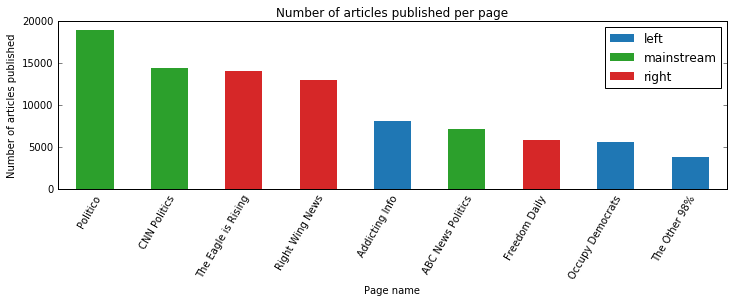

In [3]:
exploration.barplot_count_posts_per_page(df)

The two most active pages are the two mainstream pages *Politico* (with ~19k articles posted) and *CNN* (with ~15k articles posted). In contrast, the two least active pages are the pro-democrat pages *The Other 98%* (with ~4k articles posted) and *Occupy Democrats* (with ~6k articles posted).

### Boxplots of number of comments/reactions/shares for each page

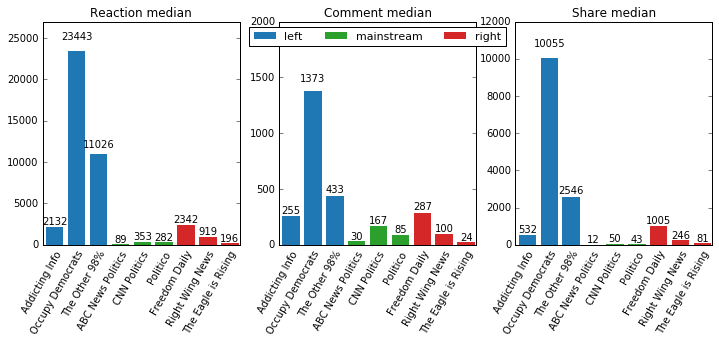

In [4]:
exploration.barplot_engagement(df, agg_func='median')

It is interesting to note that the two pages that posted the least are the ones who generated, in average, the most user engagement (in terms of number of reactions, comments and shares).

---

## 2.2 Time Series Visualization

Let us now investigate how the articles and their reactions unfold over time. To better visualize the data, we aggregate articles by week, using the week number in year 2016.

In [5]:
# Extract the week number when the article was created
df['created_week'] = df['created_time'].apply(lambda row: row.isocalendar()[1])

### Number of Articles Published each Week for each Page

In [6]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [7]:
p = figure(title='Number of articles published each week for each page', plot_width=950, plot_height=400)
for i, page_name in enumerate(df.page_name.unique()):
    s = df[df.page_name==page_name]['created_week'].value_counts().sort_index()
    p.line(x=s.index, y=np.array(s), color=palette[i], legend=page_name, line_width=2)
p.xaxis.axis_label = 'Week of the year 2016'
p.yaxis.axis_label = 'Number of articles published'
p.legend.location = 'top_left'
show(p)

The three mainstream pages (*i.e.* *Politico*, *CNN* and *ABCNewsPolitics*) exhibit the same peak around weeks 29-30. This time period corresponds to the primary election of the Democratic National Convention. In addition, the peak at week 45 corresponds to articles released on the week of the election which was held on  November 8. We can clearly see a big drop for all pages 2 weeks after the election was held.

### Number of Comments Published each Week for each Page

In [8]:
p = figure(title='Number of comments published each week for each page', plot_width=950, plot_height=400)
for i, page_name in enumerate(df.page_name.unique()):
    s = df[df.page_name==page_name].groupby('created_week').sum()['comment_count']
    p.line(x=s.index, y=np.array(s), color=palette[i], legend=page_name, line_width=2)
p.xaxis.axis_label = 'Week of the year 2016'
p.yaxis.axis_label = 'Number of comments'
p.legend.location = 'top_left'
show(p)

---

## 2.3 Analysis of the Text Messages

### Analysis of Message Length

Let us first investage the length of the messages under different perspectives.

In [9]:
# Compute the length of each text message
df['Message length'] = df['message'].fillna('').apply(lambda s: len(s))

*How does the message length differ between political orientation categories?*

In [10]:
exploration.aggregate_message_length(df, by='category', agg_funcs=['median']).T

,Category,left,mainstream,right
Message length,median,55,134,64


*How does the message length differ between each page?*

In [11]:
exploration.aggregate_message_length(df, by='page_name', agg_funcs=['median']).T

,Page name,ABC News Politics,Addicting Info,CNN Politics,Freedom Daily,Occupy Democrats,Politico,Right Wing News,The Eagle is Rising,The Other 98%
Message length,median,172,64,168,166,61,104,36,71,18


On the first table above, we see that the mainstream pages have longer messages than the others. If we look closer to the median length of messages per page, we see that `The Other 98%` (democrat oriented) and `Right Wing News` (republican oriented) have much shorter text messages than any other pages. Let us look at a few examples of such short messages for the page `The Other 98%`:

In [12]:
df['message'][(df.page=='TheOther98')&(df['Message length'] < 10)&(df['Message length'] > 0)][:15]

87136      Better.
87137         Yep.
87138         Amen
87141      MmmHmm.
87143          Ha!
87153         WOW!
87157    BREAKING:
87161       Neato!
87166    BREAKING:
87174        Word.
87185       Ditto.
87186         YES!
87188          Yep
87191         Amen
87196        Word.
Name: message, dtype: object

We can see that these short messages are undeniably subjective and biased. In contrast, we can see below that long messages seem to be more objective. This observation might be interpreted as ***short* click-bait** messages versus ***long* story-telling** articles.

In [13]:
pd.options.display.max_colwidth = 100
print(df['message'][(df.page=='cnnpolitics')&(df['Message length'] > 100)][:5])

15280    Whether it's the messenger or the message, Democrats agree something needs to change following t...
15281    In a statement, Carrier says, “the incentives offered by the state were an important considerati...
15282    The destiny of US diplomacy is coming down to a process of elimination between Republican giants...
15283    President-elect Donald J. Trump has been known to favor Kentucky Fried Chicken, McDonald's and t...
15284    Michael Banerian, the youth vice-chairman of the Michigan Republican Party, says he has been thr...
Name: message, dtype: object


### Text Features Analysis

Let us now dive deeper into the text messages and explore the relevant terms that we will use as text features in the data exploitation part. We start by vectorizing the raw text messages into a matrix counting the occurences of each word in each post.

In [14]:
X, vectorizer = exploration_helper.vectorize_messages(df.message.fillna(''))
print("There are {} messages with {} bag-of-word features.".format(*X.shape))

There are 90934 messages with 8143 bag-of-word features.


In [15]:
counts = exploration.count_words(X, vectorizer)
counts[:20].to_frame('Count').T

,trump,donald,hillary,clinton,http,obama,president,says,just,like,ws,abcn,cnn,campaign,new,said,video,sanders,republican,bernie
Count,22089,14601,10419,10035,8636,7209,6642,6189,5050,4900,4790,4786,4407,4190,4043,3775,3497,3369,3368,3275


### Rating vs. Political Orientation Category

Only the labelled messages will actually be useful to us to train the models in the exploitation section. Do the words used in posts rated as `mostly true` differ from the ones rated as `mostly false`?

On the tables below, we can see that the top words of both classes share many common words like `trump`, `domald`, `obama`, `clinton`, `hillary`, ... However, it is interesting to note that the 10-th most used word of the `mostly false` articles is `muslim` and that the 17-th one is `lie`.

In [16]:
# Define the masks for the true and false articles.
mask_true = np.array(df.rating == 'mostly true')
mask_false = np.array(df.rating == 'mostly false')

#### Top vocabulary words of `mostly true` articles

In [17]:
# Count the word frequency of posts rated as `mostly true`
counts = exploration.count_words(X[mask_true,:], vectorizer)
# Print the top 50 words
pd.set_option("display.max_columns", 50)
counts[:50].to_frame('Count').T

,trump,donald,clinton,hillary,debate,president,says,obama,http,presidential,cnn,said,new,just,campaign,like,police,ws,abcn,people,debates,democrats,did,white,going,election,state,black,think,republican,video,america,say,voters,know,don,american,stop,country,national,night,politico,york,man,nominee,occupy,make,candidate,news,americans
Count,560,449,324,282,158,143,135,111,108,108,98,88,81,77,74,71,66,65,65,59,57,52,47,47,46,45,44,43,43,42,42,41,40,39,38,37,36,36,35,35,34,33,33,33,32,32,31,31,31,31


#### Top vocabulary words of `mostly false` articles

In [18]:
# Count the word frequency of posts rated as `mostly false`
counts = exploration.count_words(X[mask_false,:], vectorizer)
# Print the top 50 words
pd.set_option("display.max_columns", 50)
counts[:50].to_frame('Count').T

,hillary,clinton,obama,just,trump,media,america,liberal,let,muslim,new,000,shares,going,share,went,lie,police,said,time,foundation,com,come,video,illegal,world,charity,run,disgusting,like,sued,general,refugees,hell,news,live,caught,eaglerising,need,believe,white,www,completely,obvious,way,think,clintons,make,happening,attacked
Count,19,12,11,11,10,8,7,7,6,6,5,5,5,4,4,4,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2


---

## 2.4 Exploration of Other Non-Text Discriminative Features in Fake News Articles

Let us now explore other non-textual features to analyze if they clearly separate fake-news from legitimate ones.

In [19]:
# Mask all articles that have not been manually annotated
mask_labelled = df.rating != 'UNKNOWN'

### Rating vs. Political Orientation Category

Let us first investigate the **proportions of genuine and fake-news articles based on the political orientation** of the pages. The Figure below clearly shows that the mainstream pages contain much less fake content than politically oriented pages. 

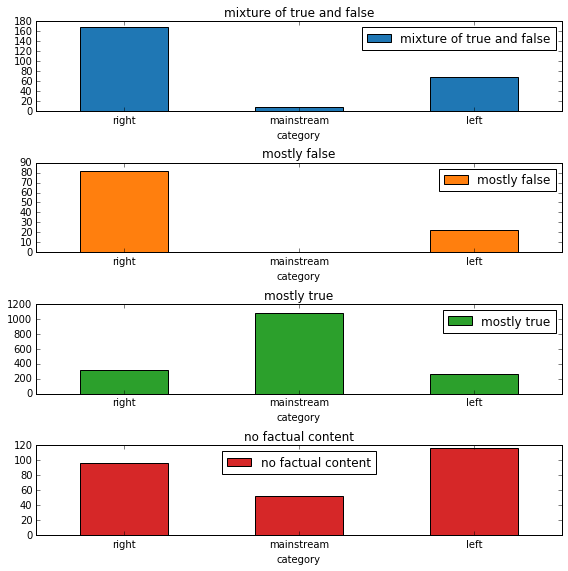

In [20]:
exploration.count_group(df[mask_labelled], by=['rating', 'category'])

### Rating vs. Page

Let us now analyze this behavior per page in more depth, with the **number of `mostly false` news for each page**. The `no factual content` rating from the mainstream media correspond in 100% of the cases to news advertising for their own content. The ones for the right and left media are all jokes and subjective content. The Figure below clearly shows that the pro-left `Occupy Democrats` and the pro-right `The Eagle is Rising` are to two most active distributors of fake-news.

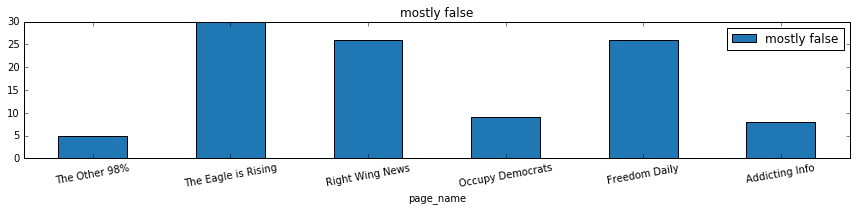

In [47]:
mask_false = (df.rating == 'mostly false')
exploration.count_group(df[mask_false], by=['rating', 'page_name'], figsize=(12,3), rot=10)

### Rating vs. Type of content

Now that we know which are the most likely pages to publish fake-news, it is natural to wonder whether **the `type` of content** published (i.e. `status`, `link`, `photo`, `video`) distinguishes the truthfulness of the articles.

On the table below, we can see that most articles are links. A manual inspection actually shows that they are links to full articles hosted on the websites of the respective pages, with a short summary text message. There is no clear difference between `mostly true` and `mostly false` articles. However, we clearly see that articles with `no factual content` (*i.e.* articles that are satirical, opinion-driven, or that otherwise lacked a factual claim) are mostly photos and videos, whereas both types are mostly absent of all other rating classes.

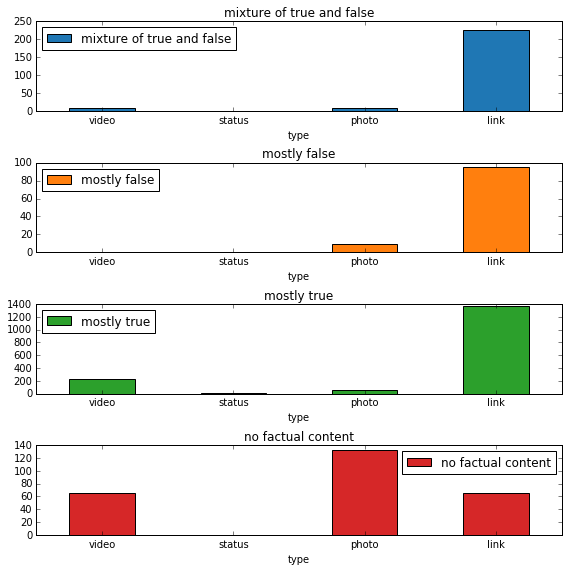

In [22]:
exploration.count_group(df[mask_labelled], by=['rating', 'type'], figsize=(8,8))

### Rating vs. Number of shares/comments/reactions

Let us finally explore which articles raised the most engagement and what is their rating. On the plots below, we show the number of reactions, comments and shares with respect to the article rating for each political orientation category. The 9 plots are organized as follows:
* The first line corresponds to pro-democrat pages, 
* the second line corresponds to mainstream pages, 
* and the last line corresponds to pro-republican pages.

We see that the posts published by pro-democrat pages that raised the most engagement are the ones with `no factual content` (i.e. posts that are satirical, opinion-driven, or that otherwise lacked a factual claim). In contrast, pro-republican posts rated as `mostly false` (i.e. fake-news posts) are the ones that raised the most engagement from their readers. Finally, we also see that the posts published by mainstream pages that raised the most engagement are rated as `mixture of true and false`.

It is interesting to note that, for each category, results agree for all three engagement metrics (i.e. number of reactions, comments and shares).

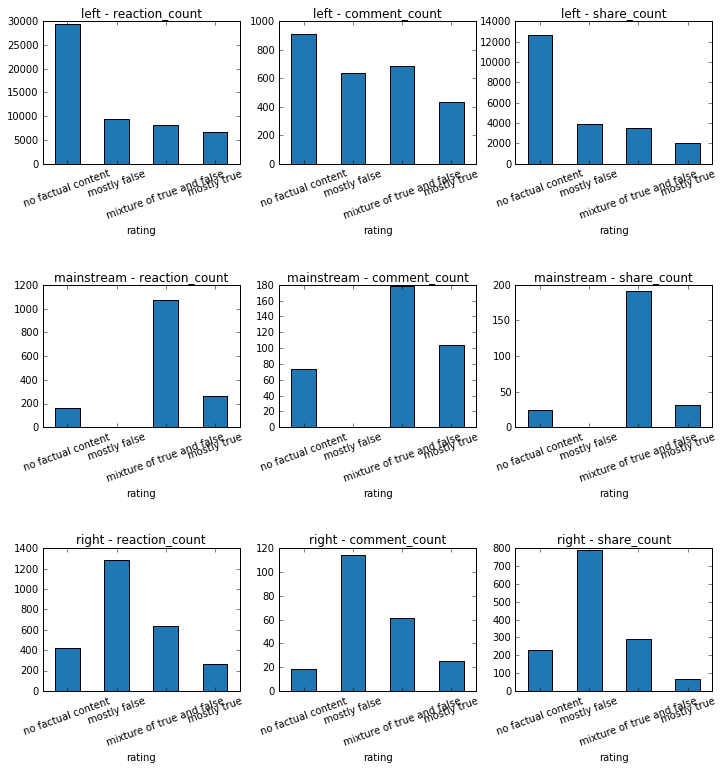

In [23]:
RATINGS =  ['no factual content', 'mostly false', 'mixture of true and false', 'mostly true']
CATEGORIES = ['left', 'mainstream', 'right']
ENGAGEMENT_COLUMNS = ['reaction_count','comment_count','share_count']

fig, axs = plt.subplots(len(CATEGORIES), len(ENGAGEMENT_COLUMNS), figsize=(12,12))
for i, cat in enumerate(CATEGORIES):
    for j, col in enumerate(ENGAGEMENT_COLUMNS):
        data = df[df.category==cat][['rating',col]].groupby('rating').agg('median').reindex(RATINGS) 
        data.plot.bar(ax=axs[i][j], rot=20, legend=False)
        axs[i][j].set_title('{} - {}'.format(cat,col))
fig.subplots_adjust(hspace=0.85)

---

# 3. Data Exploitation

Now that we have a pretty good idea of the data we are dealing with, we can implement a model to detect fake-news articles for the various features we discussed earlier. To tackle this task, we take inspiration from sentiment analysis models whose goal is to detect happiness and sadness in text data.

In [24]:
# (Re)load the dataset
df = utils.load_dataset('data/dataset.csv')

## 3.1 Fake-News Classification using Naive Bayes

A widly used model for sentiment classification is the Naive Bayes model. The assumption behind this model is that all features (i.e. words in the vocabulary) are conditionally independent given the class. This assumption allows a nice and simple mathematical derivation of the learning algorithm.

In [25]:
from lib.exploitation import NaiveBayesClassifier

### Preprocessing

Format the dataframe and split the dataset into a training and a held out testing set.

Using the bag-of-words assumption, the messages are tokenized into words and we use the widely used "tf-idf" normalization of features, whose formula is as follows:

$$\text{tf-idf}(w,m) = \frac{\text{Number of times word } w \text{ appears in message } m}{\text{Number of messages in which word } w \text{ occurs}}.$$

This measure emphasizes words that occur a lot in a single message but are rare in the whole corpus.


In [26]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [27]:
# Filter the data to consider only posts labeled as 'mostly true' and 'mostly false'
mask_true_false = (df.rating == 'mostly true') | (df.rating == 'mostly false')
X, vectorizer = exploration_helper.vectorize_messages(df[mask_true_false].message.fillna(''), vectorizerObj=TfidfVectorizer)
y = np.array(df[mask_true_false].rating == 'mostly false', dtype='bool')
print("There are {} labeled messages with {} bag-of-word features.".format(*X.shape))
print("There are {} legitimate messages and {} fake ones.".format((y==0).sum(), (y==1).sum()))

There are 1766 labeled messages with 311 bag-of-word features.
There are 1662 legitimate messages and 104 fake ones.


In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("There are {} legitimate messages and {} fake ones in the training set.".format((y_train==0).sum(), (y_train==1).sum()))
print("There are {} legitimate messages and {} fake ones in the testing set.".format((y_test==0).sum(), (y_test==1).sum()))

There are 1148 legitimate messages and 88 fake ones in the training set.
There are 514 legitimate messages and 16 fake ones in the testing set.


### Hyperparameter tuning

The Naive Bayes model has two hyperparameters that need to be tuned. 
- The first one corresponds to the **smoothing** parameter `alpha` used to avoid overfitting due to features with very small probabilities. 
- The second one corresponds to the `class_prior` parameter which aims at reducing the bias due to unbalanced data.

The first plot (on the left) below shows that small `alpha` (.e.g `1.0`) should be used. A higher value seems to smooth the features too much, thus reducing their discriminative power. The other plot (on the right) shows that a prior between `0.3` and `0.4` should be used for the fake-news class. 

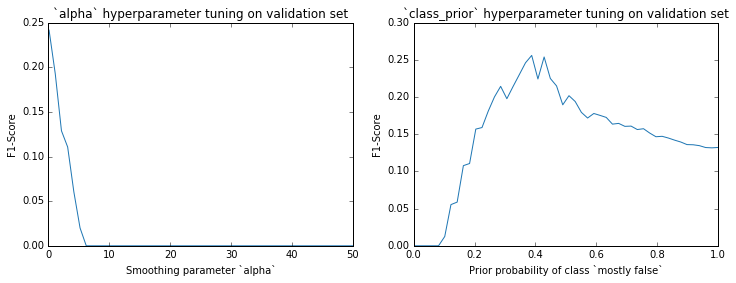

In [29]:
# Tune the `alpha` hyperparameter
nb_classifier = NaiveBayesClassifier(class_prior=[0.7, 0.3])
alpha_search_space = np.linspace(0.1, 50.0, 50.0)
alpha_search_perf = nb_classifier.tune_alpha(X_train, y_train, alpha_search_space)

# Tune the `class_prior` hyperparameter
nb_classifier = NaiveBayesClassifier(alpha=1.0)
prior_search_space = np.linspace(0.0, 1.0, 50.0)
prior_search_perf = nb_classifier.tune_prior(X_train, y_train, prior_search_space)

fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(alpha_search_space, alpha_search_perf)
axs[0].set_ylabel("F1-Score"); axs[0].set_xlabel("Smoothing parameter `alpha`");
axs[0].set_title("`alpha` hyperparameter tuning on validation set")
axs[1].plot(prior_search_space, prior_search_perf)
axs[1].set_ylabel("F1-Score"); axs[1].set_xlabel("Prior probability of class `mostly false`");
axs[1].set_title("`class_prior` hyperparameter tuning on validation set");

### Evaluation

Once the hyperparameters are tuned, we can evaluate the performances of the Naive Bayes model on the held out testing dataset. We can see below that the the model achieves a good accuracy. However, since our dataset is highly unbalanced, accuracy actually hides the fact that the model is only performing well at classifying the `mostly true` articles. Looking at the second line of the confusion matrix shows that, among the $19$ fake-news articles of the testing set, the model is actually wrongly classifying $11$ as legitimate.

Due to the class imbalance, it is thus much more relevant to evaluate the model using the $F_1$-score. Indeed, this metric defined as:

$$F_1 = 2 \cdot \frac{\text{precision}\cdot\text{recall}}{\text{precision}+\text{recall}},$$
where
$$\text{precision} = \frac{\text{True positive}}{\text{True positive}+\text{False positive}}, ~\text{and}~ \text{recall} = \frac{\text{True positive}}{\text{True positive}+\text{False negative}}.$$

Taking into account both the `precision` and `recall` instead of the `accuracy` avoids high scores due to imbalanced datasets.

In [30]:
nb_classifier = NaiveBayesClassifier(alpha=1.0, class_prior=[0.6, 0.4])
# Train the model on the trainin set
nb_classifier.fit(X_train, y_train)
# Evaluate the model on the heldout testing set
_, nb_performance_metrics = nb_classifier.predict(X_test, y_test)
print('Accuracy:', nb_performance_metrics['accuracy'])
print('F1 score:', nb_performance_metrics['f1_score'])
print('Confusion Matrix:\n', nb_performance_metrics['confusion_matrix'])

Accuracy: 0.87358490566
F1 score: 0.12987012987
Confusion Matrix:
 [[458  56]
 [ 11   5]]


## 3.2 Fake-News Classification using Convolutional Neural Network
We implement here a method to predict the truthfulness of a post using a Convolutional Neural Network. We vectorize the sentences by mapping each word to an index in the vocabulary of the whole corpus. The extracted vocabulary has size 6490. Word embeddings are then learned directly by the network. The architecture is built such that filters of different sizes (2, 3, 4 and 5 in our case) consecutively process the embedded words, sliding over different numbers of words at the same time (i.e. convolution).

We use a dropout probability $p=0.5$, as well as an $L_2$-regularizer with $\lambda = 0.1$ in order to countereffect overfitting. 

Reference: http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/

### Preprocess the data
We preprocess the texts by padding them such that they all have the same length.

In [31]:
from lib.exploitation_helper import preprocessing

X, y, vocabulary = preprocessing(df)

print("There are {} labeled messages whose maximum length is {}.".format(*X.shape))
print("There are {} true messages and {} false ones.".format(y[:, 0].sum(), y[:, 1].sum()))

There are 1766 labeled messages whose maximum length is 89.
There are 1662 true messages and 104 false ones.


#### Training and Evaluation

Train the CNN on the data. Batches of size 64 samples are randomly generated and the whole training set is processed for 10 epochs.

The evaluation is done simultaneously by testing the model on a heldout testing dataset.

Note: the `nan` values displayed for the F1 score for a couple of iterations is due to the highly unbalanced data.

In [32]:
from lib.exploitation import CNNClassifier

model = CNNClassifier(X, 
                      y, 
                      vocabulary, 
                      test_sample_percentage=0.3,
                      filter_sizes=[2, 3, 4, 5],
                      dropout_keep_prob=0.5,
                      l2_reg_lambda=0.1,
                      batch_size=64, 
                      num_epochs=10, 
                      evaluate_every=5)

loss, accuracy, f1_score = model.fit()

Vocabulary size: 6490
Train/test split: 1237/529`>
Writing to /Users/kristof/GitHub/ntds_2016/prj-fake-news/runs/1484506616

2017-01-15T19:57:00.912270: step 1, loss 1.2138, acc 0.625, f1 0.0769231
2017-01-15T19:57:01.281131: step 2, loss 0.890614, acc 0.78125, f1 0.125
2017-01-15T19:57:01.629120: step 3, loss 1.1517, acc 0.8125, f1 nan
2017-01-15T19:57:01.965870: step 4, loss 0.793367, acc 0.9375, f1 nan
2017-01-15T19:57:02.301126: step 5, loss 0.51815, acc 0.953125, f1 nan

Evaluation:
2017-01-15T19:57:03.280443: step 5, loss 0.736578, acc 0.943289, f1 nan

2017-01-15T19:57:03.643570: step 6, loss 1.08518, acc 0.921875, f1 nan
2017-01-15T19:57:03.990908: step 7, loss 0.649553, acc 0.921875, f1 nan
2017-01-15T19:57:04.334797: step 8, loss 0.895872, acc 0.921875, f1 nan
2017-01-15T19:57:04.723266: step 9, loss 0.559493, acc 0.953125, f1 nan
2017-01-15T19:57:05.068046: step 10, loss 0.808965, acc 0.921875, f1 nan

Evaluation:
2017-01-15T19:57:05.924707: step 10, loss 0.692098, acc 0.943

In [33]:
print("Test accuracy: %.4f" % accuracy)
print("Test F1-Score: %.4f" % f1_score)

Test accuracy: 0.9509
Test F1-Score: 0.2353


### Inspect Results

Open TensorBoard to inspect the results of the training.

Change `MODEL_ID` (or the 10-digit number in the path) by the value returned by the following cell:

INFO: works only in **Chrome**.

In [34]:
print(model.model_id)

1484506616


In [ ]:
!tensorboard --logdir runs/1484506616/summaries/

#### Predict

Predict the truthfulness of new messages.

In [40]:
x_raw = ["Hillary just admitted Trump should be elected president.", 
         "Trump to resign from the race to the White House.",
         "ALERT: Police Pull Over Islamic Refugee, Horrified To See What Was In The Car!!! The media has swept this under the rug, but it is a severe national security threat.",
         "If Trump becomes President, this will not end well.",]

predictions = model.predict(x_raw)

for pred, message in zip(predictions, x_raw):
    if pred == 0:
        print("TRUE: ", message)
    else:
        print("FAKE: ", message)

TRUE:  Hillary just admitted Trump should be elected president.
TRUE:  Trump to resign from the race to the White House.
FAKE:  ALERT: Police Pull Over Islamic Refugee, Horrified To See What Was In The Car!!! The media has swept this under the rug, but it is a severe national security threat.
FAKE:  If Trump becomes President, this will not end well.


---

## 3.3 Fake-News Detection with Non-Textual Features: K-Nearest Neighbors Classifier

The two previous models were only based on the text messages written with the Facebook post. However, as seen in the exploration section, other non-textual features like the type of content published (*i.e.* video, photo, link or status) or the number of comments, shares and reactions are alors discriminative of the truthfulness of the information.

Therefore, we take these features, map the categorical ones to dummy variables (*a.k.a. one hot vectors*) and try detect the fake-news articles based on a K-nearest neighbors model. This model is appealing since it does not make any linearity assumption on the classification boundaries.

In [8]:
from lib.exploitation import KNNClassifier

### Preprocessing
Format the dataframe and split the dataset into a training and a heldout testing set.

In [42]:
# Filter the data to consider only posts labeled as 'mostly true' and 'mostly false'
mask_true_false = (df.rating == 'mostly true') | (df.rating == 'mostly false')
filtered_df = df[mask_true_false]

# Choose the features
knn_data = filtered_df[['comment_count', 'share_count', 'reaction_count']]
knn_data = knn_data.join(pd.get_dummies(filtered_df[['type', 'page']]))
# Rescale the features
for col in ['comment_count', 'share_count', 'reaction_count']:
    knn_data[col] = knn_data[col] / knn_data[col].max()

X = knn_data.values
y = np.array(filtered_df['rating'] == 'mostly false', dtype='bool')
print("There are {} labeled messages with {} features.".format(*X.shape))
print("There are {} legitimate messages and {} fake ones.".format((y==0).sum(), (y==1).sum()))

There are 1766 labeled messages with 16 features.
There are 1662 legitimate messages and 104 fake ones.


In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("There are {} legitimate messages and {} fake ones in the training set.".format((y_train==0).sum(), (y_train==1).sum()))
print("There are {} legitimate messages and {} fake ones in the testing set.".format((y_test==0).sum(), (y_test==1).sum()))

There are 1148 legitimate messages and 88 fake ones in the training set.
There are 514 legitimate messages and 16 fake ones in the testing set.


### Hyperparameter tuning

The only hyperparameter to tune for the $K$-nearest neigbhors model is the number of neighbors $K$ to use in the majority vote computation.

On the plot below, we see that using only $K=1$ neighbor is the value leading to the best F1-score on the validation set using cross-validation. This behavior may be explained by the imbalance of the dataset and the lack of fake-news samples in the training set.

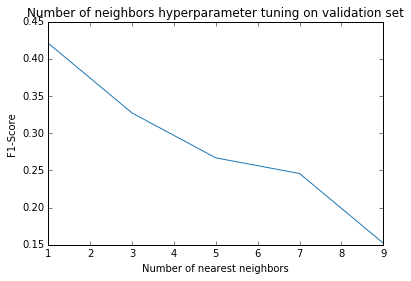

In [44]:
# Tune the hyperparameter `n_neighbors` (the number of nearest neighbors)
nb_classifier = KNNClassifier()
n_search_space = np.arange(5)*2 + 1
n_search_perf = nb_classifier.tune_n_neighbors(X_train, y_train, n_search_space)

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(n_search_space, n_search_perf)
ax.set_ylabel("F1-Score"); ax.set_xlabel("Number of nearest neighbors");
ax.set_title("Number of neighbors hyperparameter tuning on validation set");

### Evaluation

Using the non-textual on this algorithm leads to roughly the same results as the other models based on the text messages. As stated in the previous sections, this result may certainly come from the high imbalance of the data set.

In [45]:
knn_classifier = KNNClassifier(n_neighbors=1)
# Train the model on the training set
knn_classifier.fit(X_train, y_train)
# Evaluate the model on the heldout testing set
_, nb_performance_metrics = knn_classifier.predict(X_test, y_test)
print('Accuracy:', nb_performance_metrics['accuracy'])
print('F1 score:', nb_performance_metrics['f1_score'])
print('Confusion Matrix:\n', nb_performance_metrics['confusion_matrix'])

Accuracy: 0.924528301887
F1 score: 0.2
Confusion Matrix:
 [[485  29]
 [ 11   5]]


---

# Conclusion

In this project, inspired by the work from BuzzFeed, we scraped data from nine Facebook pages posting actively about the U.S. presidential elections to analyze the truthfulness of the information published. We saw that pages publishing mostly fake news typically use less words in their messages, suggesting that they are trying to craft click-bait posts. We also noticed that right-winged pages are more prone to publish mostly fake messages and mainstream pages usually publish mostly true ones. 

We then tried two text-based classifiers, namely Naive Bayes and Convolutional Neural Network, in order to fit a dataset of labelled messages. Due to a small amount of data, as well as very unbalanced classes, we could not obtain convincing results. We moreover tried to add domain-specific features to improve our predictions. For the same reasons as before, the results were not promising.

To improve upon our work, we should tackle the unbalance issue. Some techniques exist, such as subsampling or cost-sensitive classification, and should be considered. The labelled dataset covers a week of Facebook activity and we collected data over a year. This fresh data should be labelled in order to increase the size of our train set.  